In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'
symbol = 'EUR_USD'
raw = pd.read_csv(url, index_col=0, parse_dates=True)
raw.head()

,HIGH,LOW,OPEN,CLOSE
Date,,,,
2019-10-01 00:00:00,1.0899,1.0897,1.0897,1.0899
2019-10-01 00:01:00,1.0899,1.0896,1.0899,1.0898
2019-10-01 00:02:00,1.0898,1.0896,1.0898,1.0896
2019-10-01 00:03:00,1.0898,1.0896,1.0897,1.0898
2019-10-01 00:04:00,1.0898,1.0896,1.0897,1.0898


In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96526 entries, 2019-10-01 00:00:00 to 2019-12-31 23:06:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HIGH    96526 non-null  float64
 1   LOW     96526 non-null  float64
 2   OPEN    96526 non-null  float64
 3   CLOSE   96526 non-null  float64
dtypes: float64(4)
memory usage: 3.7 MB


<AxesSubplot:xlabel='Date'>

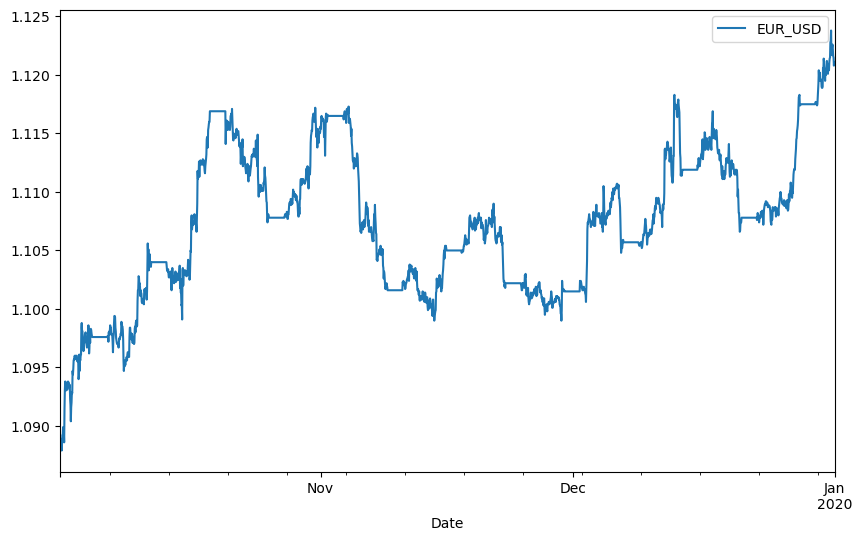

In [14]:
data = pd.DataFrame(raw['CLOSE'].loc[:]) 
data.columns = [symbol]

# Selects, resamples, and plots the closing prices
data = data.resample('1h', label='right').last().ffill()
data.plot(figsize=(10, 6))

In [5]:
# Baseline Prediction

In [15]:
lags = 5

def add_lags(data, symbol, lags, window=20):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift())
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [16]:
data, cols = add_lags(data, symbol, lags)
len(data)

2183

In [17]:
# 레이블의 불균형이 있는지 확인해 봐야함
c = data['d'].value_counts()
c

0    1445
1     738
Name: d, dtype: int64

In [18]:
def cw(df):
    c0, c1 = np.bincount(df['d'])
    w0 = (1 / c0) * (len(df)) / 2
    w1 = (1 / c1) * (len(df)) / 2
    return {0: w0, 1: w1}

In [19]:
# Calculates appropriate weights to reach an equal weighting
class_weight = cw(data)
class_weight

{0: 0.755363321799308, 1: 1.4789972899728998}

In [20]:
# With the calculated weights, both classes gain equal weight
class_weight[0] * c[0]

1091.5

In [21]:
class_weight[1] * c[1]

1091.5

In [23]:
import random
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score

In [24]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [25]:
optimizer = Adam(lr=0.001)

C:\Users\hong9\anaconda3\envs\q_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [26]:
def create_model(hl=1, hu=128, optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols),     # First layer
                   activation='relu'))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu'))  # Additional layer
    model.add(Dense(1, activation='sigmoid'))    # Output layer
    model.compile(loss='binary_crossentropy',    # Loss function
                 optimizer=optimizer,
                 metrics=['accuracy'])
    return model

In [27]:
set_seeds()
model = create_model(hl=1, hu=128)

In [28]:
%%time
model.fit(data[cols], data['d'], epochs=50,
         verbose=False, class_weight=cw(data))

CPU times: total: 16.2 s
Wall time: 9.68 s


In [32]:
model.evaluate(data[cols], data['d'])

69/69 [==============================] - 0s 2ms/step - loss: 0.6016 - accuracy: 0.5754


[0.6016420722007751, 0.5753549933433533]

In [34]:
data['p'] = np.where(model.predict(data[cols]) > 0.5, 1, 0)
data['p'].value_counts()

69/69 [==============================] - 0s 2ms/step


1    1585
0     598
Name: p, dtype: int64

In [35]:
split = int(len(data) * 0.8)
train = data.iloc[:split].copy()
test = data.iloc[split:].copy()

set_seeds()
model = create_model(hl=1, hu=128)

In [36]:
%%time
history = model.fit(train[cols], train['d'],
             epochs=50, verbose=False,
             validation_split=0.2, shuffle=False,
             class_weight=cw(train))

CPU times: total: 15.6 s
Wall time: 10.8 s


In [37]:
# Evaluates the in-sample performance
model.evaluate(train[cols], train['d'])

55/55 [==============================] - 0s 2ms/step - loss: 0.6103 - accuracy: 0.5934


[0.6102637648582458, 0.5933562517166138]

In [38]:
# Evaluates the out-of-sample performance
model.evaluate(test[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 0.5950 - accuracy: 0.6133


[0.5949892997741699, 0.6132723093032837]

In [39]:
test['p'] = np.where(model.predict(test[cols]) > 0.5, 1, 0)

14/14 [==============================] - 0s 2ms/step


In [40]:
test['p'].value_counts()

1    284
0    153
Name: p, dtype: int64

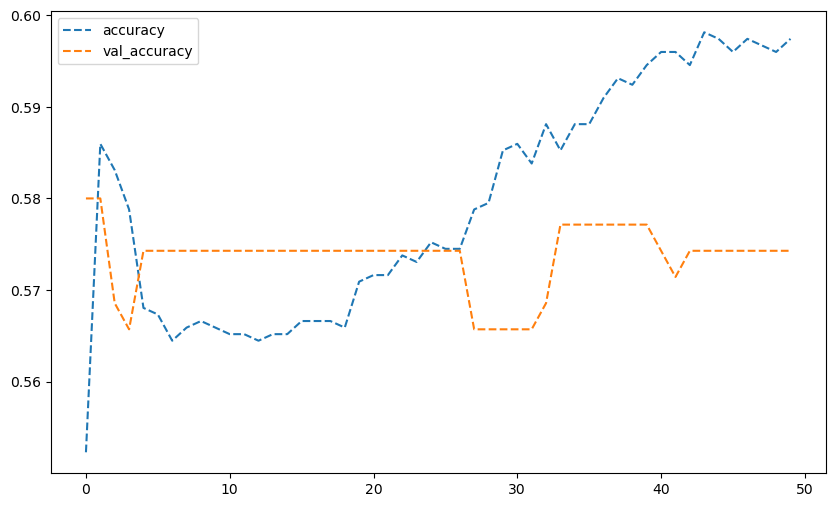

In [41]:
res = pd.DataFrame(history.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [44]:
# Normalization

In [42]:
mu, std = train.mean(), train.std() # Calculates the mean and standard deviation for all training features
train_ = (train - mu) / std         # Normalizes the training data set based on Gaussian normalization
set_seeds()
model = create_model(hl=2, hu=128)

In [43]:
%%time
history = model.fit(train_[cols], train['d'],
                   epochs=50, verbose=False,
                   validation_split=0.2, shuffle=False,
                   class_weight=cw(train))

CPU times: total: 16.2 s
Wall time: 10.3 s


In [45]:
model.evaluate(train_[cols], train['d']) # Evaluates the in-sample performance

55/55 [==============================] - 0s 2ms/step - loss: 0.4012 - accuracy: 0.9250


[0.40117281675338745, 0.924971342086792]

In [47]:
test_ = (test - mu) / std    # Normalizes the test data set based on Gaussian normalization
model.evaluate(test_[cols], test['d'])   # Evaluates the out-of-sample performance

14/14 [==============================] - 0s 2ms/step - loss: 1.5149 - accuracy: 0.6590


[1.5148553848266602, 0.6590389013290405]

In [48]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, 0)

14/14 [==============================] - 0s 2ms/step


In [49]:
test['p'].value_counts()

0    273
1    164
Name: p, dtype: int64

<AxesSubplot:>

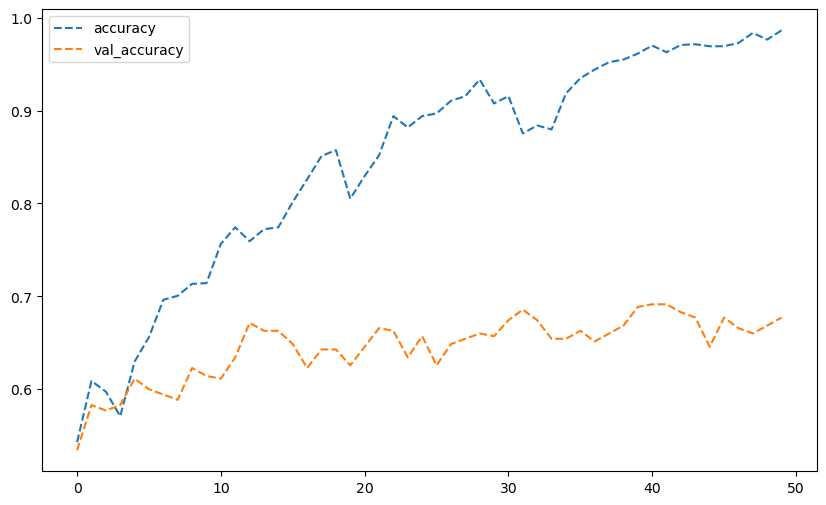

In [50]:
res = pd.DataFrame(history.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10,6), style='--')

In [51]:
# Dropout

In [52]:
from keras.layers import Dropout

In [53]:
def create_model(hl=1, hu=128, dropout=True, rate=0.3,
                optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols),
                   activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu'))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                 metrics=['accuracy'])
    return model

In [54]:
set_seeds()
model = create_model(hl=1, hu=128, rate=0.3)

In [55]:
%%time
history = model.fit(train_[cols], train['d'],
                   epochs=50, verbose=False,
                   validation_split=0.15, shuffle=False,
                   class_weight=cw(train))

CPU times: total: 15.7 s
Wall time: 10.3 s


In [56]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 2ms/step - loss: 0.4345 - accuracy: 0.7984


[0.43445172905921936, 0.7983963489532471]

In [57]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 0.5777 - accuracy: 0.6705


[0.5777180790901184, 0.6704805493354797]

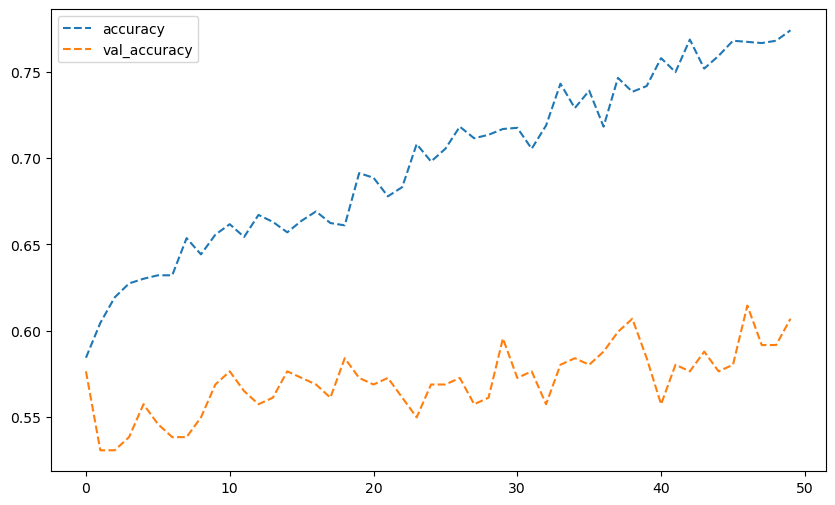

In [58]:
res = pd.DataFrame(history.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [59]:
# Regularization

In [60]:
from keras.regularizers import l1, l2

In [61]:
def create_model(hl=1, hu=128, dropout=False, rate=0.3,
                regularize=False, reg=l1(0.0005),
                optimizer=optimizer, input_dim=len(cols)):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(Dense(hu, input_dim=input_dim,
                   activity_regularizer=reg,
                   activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu',
                       activity_regularizer=reg))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                 metrics=['accuracy'])
    return model

In [62]:
set_seeds()
model = create_model(hl=1, hu=128, regularize=True)

In [63]:
%%time
history = model.fit(train_[cols], train['d'],
                   epochs=50, verbose=False,
                   validation_split=0.2, shuffle=False,
                   class_weight=cw(train))

CPU times: total: 15.5 s
Wall time: 9.9 s


In [64]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 2ms/step - loss: 0.3599 - accuracy: 0.8946


[0.35986799001693726, 0.8946162462234497]

In [65]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 0.9673 - accuracy: 0.6590


[0.9673081040382385, 0.6590389013290405]

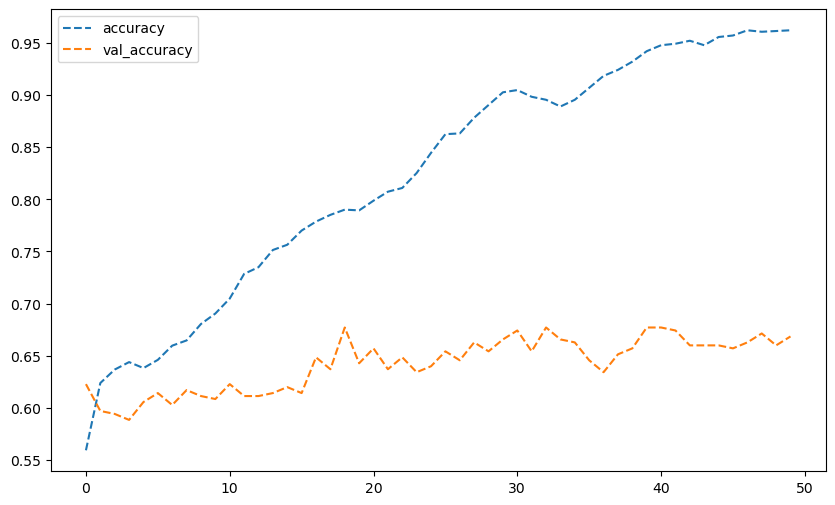

In [66]:
res = pd.DataFrame(history.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [67]:
set_seeds()
model = create_model(hl=2, hu=128,
                    dropout=True, rate=0.3, 
                    regularize=True, reg=l2(0.001), 
                    )

In [68]:
%%time
history = model.fit(train_[cols], train['d'],
                   epochs=50, verbose=False,
                   validation_split=0.2, shuffle=False,
                   class_weight=cw(train))

CPU times: total: 18.1 s
Wall time: 12 s


In [69]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 2ms/step - loss: 0.4451 - accuracy: 0.7990


[0.44508856534957886, 0.7989690899848938]

In [70]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 0.5942 - accuracy: 0.6613


[0.5941609144210815, 0.6613272428512573]

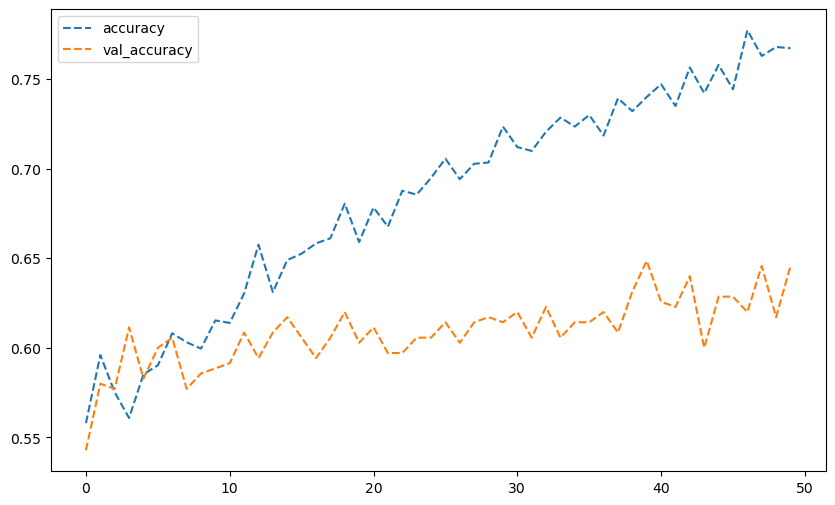

In [71]:
res = pd.DataFrame(history.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [72]:
# Bagging

In [73]:
from sklearn.ensemble import BaggingClassifier
from keras.wrappers.scikit_learn import KerasClassifier

In [74]:
max_features = 0.75

set_seeds()
base_estimator = KerasClassifier(build_fn=create_model,
                                verbose=False, epochs=20, hl=1, hu=128,
                                dropout=True, regularize=False,
                                input_dim=int(len(cols) * max_features)) 

model_bag = BaggingClassifier(base_estimator=base_estimator,
                                n_estimators=15,
                                max_samples=0.75,
                                max_features=max_features,
                                bootstrap=True,
                                bootstrap_features=True,
                                n_jobs=1,
                                random_state=100,
                                )

C:\Users\hong9\AppData\Local\Temp\ipykernel_20144\3939605057.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  base_estimator = KerasClassifier(build_fn=create_model,


In [75]:
%time
history = model_bag.fit(train_[cols], train['d'])

CPU times: total: 0 ns
Wall time: 0 ns


In [76]:
model_bag.score(train_[cols], train['d'])

55/55 [==============================] - 0s 2ms/step


0.7520045819014891

In [77]:
model_bag.score(test_[cols], test['d'])

14/14 [==============================] - 0s 2ms/step


0.6636155606407322

In [78]:
test['p'] = model_bag.predict(test_[cols])

14/14 [==============================] - 0s 2ms/step


In [79]:
test['p'].value_counts()

0    393
1     44
Name: p, dtype: int64

In [121]:
# Optimizer

In [80]:
import time

In [81]:
optimizers = ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

In [82]:
%%time
for optimizer in optimizers:
    set_seeds()
    model = create_model(hl=1, hu=128,
                        dropout=True, rate=0.3,
                        regularize=False, reg=l2(0.001),
                        optimizer=optimizer
                        ) 
    t0 = time.time()
    model.fit(train_[cols], train['d'],
                epochs=50, verbose=False,
                validation_split=0.2, shuffle=False,
                class_weight=cw(train)) 
    t1 = time.time()
    t = t1 - t0
    acc_tr = model.evaluate(train_[cols], train['d'], verbose=False)[1] 
    acc_te = model.evaluate(test_[cols], test['d'], verbose=False)[1] 
    out = f'{optimizer:10s} | time[s]: {t:.4f} | in-sample={acc_tr:.4f}'
    out += f' | out-of-sample={acc_te:.4f}'
    print(out)

sgd        | time[s]: 9.8330 | in-sample=0.6346 | out-of-sample=0.6728
rmsprop    | time[s]: 11.7006 | in-sample=0.7726 | out-of-sample=0.6522
adagrad    | time[s]: 11.0650 | in-sample=0.6254 | out-of-sample=0.6613
adadelta   | time[s]: 11.1810 | in-sample=0.3396 | out-of-sample=0.3501
adam       | time[s]: 11.3239 | in-sample=0.7721 | out-of-sample=0.6407
adamax     | time[s]: 10.5676 | in-sample=0.6770 | out-of-sample=0.6293
nadam      | time[s]: 11.9358 | in-sample=0.7749 | out-of-sample=0.6499
CPU times: total: 1min 45s
Wall time: 1min 21s


# CNN

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
url = 'http://hilpisch.com/aiif_eikon_eod_data.csv' 
symbol = 'EUR=' 
data = pd.DataFrame(pd.read_csv(url, index_col=0, parse_dates=True).dropna()[symbol]) 
data.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [3]:
lags = 5
features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
def add_lags(data, symbol, lags, window=20, features=features):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift(1))
    df['sma'] = df[symbol].rolling(window).mean() 
    df['min'] = df[symbol].rolling(window).min() 
    df['max'] = df[symbol].rolling(window).max() 
    df['mom'] = df['r'].rolling(window).mean() 
    df['vol'] = df['r'].rolling(window).std() 
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [4]:
data, cols = add_lags(data, symbol, lags, window=20, features=features)

split = int(len(data) * 0.8)
train = data.iloc[:split].copy()

mu, std = train[cols].mean(), train[cols].std() 
train[cols] = (train[cols] - mu) / std 
test = data.iloc[split:].copy() 
test[cols] = (test[cols] - mu) / std

In [5]:
import random
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten

In [6]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [7]:
set_seeds()
model = Sequential()
model.add(Conv1D(filters=96, kernel_size=5, activation='relu',
            input_shape=(len(cols), 1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 36, 96)            576       
                                                                 
 flatten (Flatten)           (None, 3456)              0         
                                                                 
 dense (Dense)               (None, 10)                34570     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 35,157
Trainable params: 35,157
Non-trainable params: 0
_________________________________________________________________


In [9]:
%%time
history = model.fit(np.atleast_3d(train[cols]), train['d'],
                epochs=60, batch_size=48, verbose=False,
                validation_split=0.15, shuffle=False)

CPU times: total: 22 s
Wall time: 10.8 s


In [10]:
res = pd.DataFrame(history.history)
res.tail(3)

,loss,accuracy,val_loss,val_accuracy
57,0.659490,0.551093,0.691454,0.531773
58,0.657872,0.552274,0.693861,0.535117
59,0.660265,0.549911,0.694187,0.538462


<AxesSubplot:>

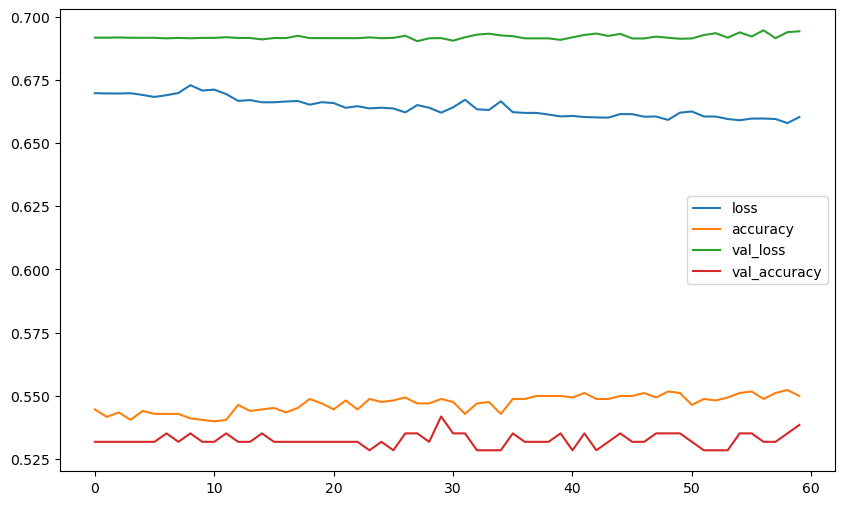

In [11]:
res.plot(figsize=(10, 6))

In [12]:
model.evaluate(np.atleast_3d(test[cols]), test['d'])

16/16 [==============================] - 0s 2ms/step - loss: 0.7106 - accuracy: 0.4770


[0.7106021046638489, 0.4769538938999176]

In [13]:
test['p'] = np.where(model.predict(np.atleast_3d(test[cols])) > 0.5, 1, 0)
test['p'] = np.where(test['p'] > 0, 1, -1) 
test['p'].value_counts()

16/16 [==============================] - 0s 3ms/step


 1    487
-1     12
Name: p, dtype: int64

In [14]:
(test['p'].diff() != 0).sum()

25

In [15]:
test['s'] = test['p'] * test['r']

In [16]:
ptc = 0.00012 / test[symbol]

test['s_'] = np.where(test['p'] != 0, test['s'] - ptc, test['s'])
test[['r', 's', 's_']].sum().apply(np.exp)

r     0.931992
s     0.909912
s_    0.863670
dtype: float64

<AxesSubplot:xlabel='Date'>

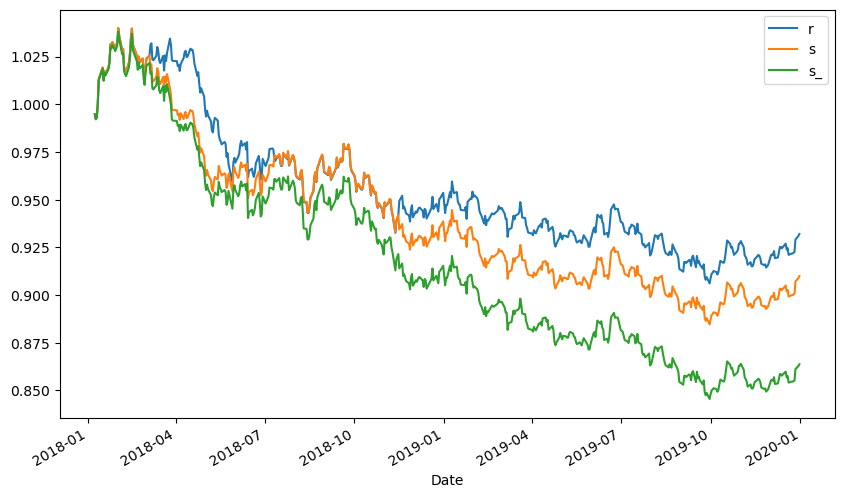

In [17]:
test[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6))